In [1]:
#Data source: https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html

pip install xarray netCDF4

  Using cached netcdf4-1.7.1.post2.tar.gz (827 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Package hdf5 was not found in the pkg-config search path.
      Perhaps you should add the directory containing `hdf5.pc'
      to the PKG_CONFIG_PATH environment variable
      No package 'hdf5' found
      reading from setup.cfg...
          HDF5_DIR environment variable not set, checking some standard locations ..
      checking /Users/gregniemeyer/include...
      hdf5 headers not found in /Users/gregniemeyer/include
      checking /usr/local/include...
      hdf5 headers not found in /usr/local/include
      checking /sw/include...
      hdf5 headers not found in /sw/include
      checking /opt/include...
      hdf5 headers not found in /opt/include
      checking /opt/local/include...
   

In [4]:
import xarray as xr

# Open the .nc file using xarray
ds = xr.open_dataset('../data/HadISST_sst.nc')

In [5]:
ds_head = ds.isel(time=slice(0, 5))

# Print the selected data
print(ds)

<xarray.Dataset> Size: 480MB
Dimensions:    (time: 1853, nv: 2, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 15kB 1870-01-16T11:59:59.505615234 ... 2...
  * latitude   (latitude) float32 720B 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) float32 15kB ...
    sst        (time, latitude, longitude) float32 480MB ...
Attributes:
    Title:                      Monthly version of HadISST sea surface temper...
    description:                HadISST 1.1 monthly average sea surface tempe...
    institution:                Met Office Hadley Centre
    source:                     HadISST
    reference:                  Rayner, N. A., Parker, D. E., Horton, E. B., ...
    Conventions:                CF-1.0
    history:                    13/7/2024 converted to netcdf from pp format
    supplementary_information: 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
# Select the sst data for the specific latitude and longitude for all available dates
sst_data = ds['sst'].sel(latitude=25, longitude=-79.6, method='nearest')

# Convert the data to a pandas DataFrame with 'time' and 'sst' columns
df = sst_data.to_dataframe().reset_index()[['time', 'sst']]

# Print the DataFrame
print(df)

                              time        sst
0    1870-01-16 11:59:59.505615234  24.048920
1    1870-02-14 23:59:59.340820312  23.515476
2    1870-03-16 11:59:59.340820312  23.822947
3    1870-04-15 23:59:59.340820312  24.999462
4    1870-05-16 12:00:00.000000000  26.154400
...                            ...        ...
1848 2024-01-16 12:00:00.000000000  24.964294
1849 2024-02-15 12:00:00.000000000  24.332855
1850 2024-03-16 12:00:00.000000000  25.346775
1851 2024-04-16 00:00:00.000000000  25.957760
1852 2024-05-16 12:00:00.000000000  27.814682

[1853 rows x 2 columns]


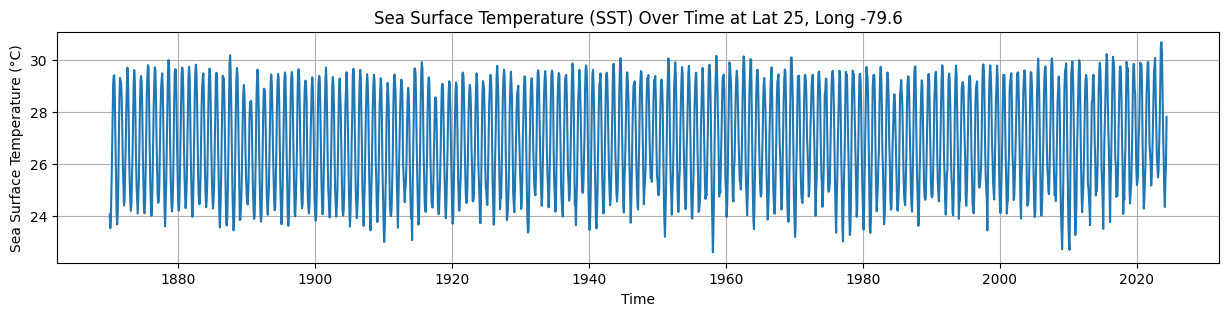

In [7]:
df['time'] = pd.to_datetime(df['time'])

# Plotting the sea surface temperature (sst) over time
plt.figure(figsize=(15, 3))
plt.plot(df['time'], df['sst'])
plt.xlabel('Time')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Sea Surface Temperature (SST) Over Time at Lat 25, Long -79.6')
plt.grid(True)
plt.show()

In [8]:
#interpolate ssl to 7200 data points
import numpy as np

num_points = 7200

# Generate a new index for the interpolated data points (linear space between min and max of original time)
new_time_index = pd.date_range(start=df['time'].min(), end=df['time'].max(), periods=num_points)

# Create a new DataFrame with the new time index
df_interpolated = pd.DataFrame({'time': new_time_index})

# Set the time column as the index for both original and new DataFrames
df.set_index('time', inplace=True)
df_interpolated.set_index('time', inplace=True)

# Perform linear interpolation to match the new index
df_interpolated['sst'] = np.interp(
    np.linspace(0, len(df) - 1, num_points),  # New equally spaced index positions
    np.arange(len(df)),  # Original index positions
    df['sst']  # Original sst values
)

# Reset index to have 'time' back as a column
df_interpolated.reset_index(inplace=True)

# Display the resulting interpolated DataFrame
print(df_interpolated)

                              time        sst
0    1870-01-16 11:59:59.505615234  24.048920
1    1870-01-24 07:55:09.465400535  23.911687
2    1870-02-01 03:50:19.425185837  23.774455
3    1870-02-08 23:45:29.384971138  23.637222
4    1870-02-16 19:40:39.344756440  23.524403
...                            ...        ...
7195 2024-04-15 04:19:20.160859522  25.940022
7196 2024-04-23 00:14:30.120644994  26.381558
7197 2024-04-30 20:09:40.080430466  26.859266
7198 2024-05-08 16:04:50.040215938  27.336974
7199 2024-05-16 12:00:00.000000386  27.814682

[7200 rows x 2 columns]


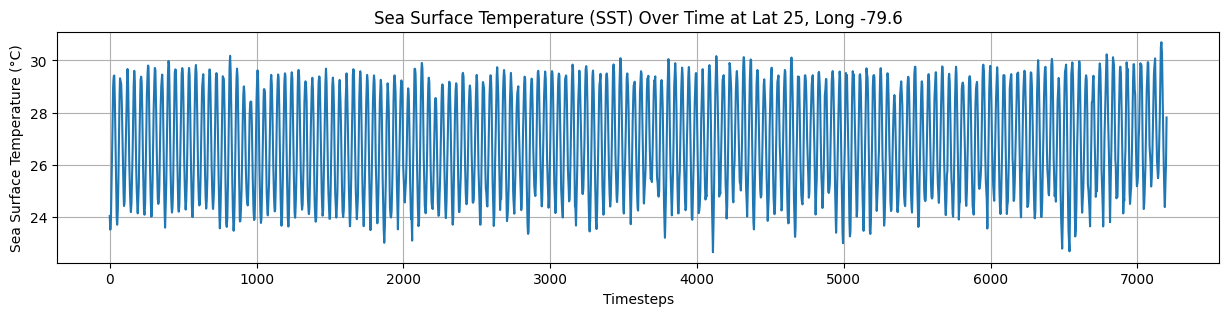

In [9]:
# Plotting the sea surface temperature (sst) over time
plt.figure(figsize=(15, 3))
plt.plot(df_interpolated.index, df_interpolated['sst'])
plt.xlabel('Timesteps')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Sea Surface Temperature (SST) Over Time at Lat 25, Long -79.6')
plt.grid(True)
plt.show()

In [10]:
#compare with a location far north: 46.341486, -58.695790
# Select the sst data for the specific latitude and longitude for all available dates
sst_data = ds['sst'].sel(latitude=26, longitude=-58.6, method='nearest')

# Convert the data to a pandas DataFrame with 'time' and 'sst' columns
df_north = sst_data.to_dataframe().reset_index()[['time', 'sst']]

# Print the DataFrame
print(df_north)

                              time        sst
0    1870-01-16 11:59:59.505615234  23.026119
1    1870-02-14 23:59:59.340820312  22.267895
2    1870-03-16 11:59:59.340820312  22.342323
3    1870-04-15 23:59:59.340820312  22.877159
4    1870-05-16 12:00:00.000000000  23.925922
...                            ...        ...
1848 2024-01-16 12:00:00.000000000  23.970846
1849 2024-02-15 12:00:00.000000000  23.139923
1850 2024-03-16 12:00:00.000000000  23.389513
1851 2024-04-16 00:00:00.000000000  23.692831
1852 2024-05-16 12:00:00.000000000  24.996683

[1853 rows x 2 columns]


In [11]:
# Generate a new index for the interpolated data points (linear space between min and max of original time)
new_time_index = pd.date_range(start=df_north['time'].min(), end=df_north['time'].max(), periods=num_points)

# Create a new DataFrame with the new time index
df_north_interpolated = pd.DataFrame({'time': new_time_index})

# Set the time column as the index for both original and new DataFrames
df_north.set_index('time', inplace=True)
df_north_interpolated.set_index('time', inplace=True)

# Perform linear interpolation to match the new index
df_north_interpolated['sst'] = np.interp(
    np.linspace(0, len(df_north) - 1, num_points),  # New equally spaced index positions
    np.arange(len(df_north)),  # Original index positions
    df_north['sst']  # Original sst values
)

# Reset index to have 'time' back as a column
df_north_interpolated.reset_index(inplace=True)

# Display the resulting interpolated DataFrame
print(df_north_interpolated)

                              time        sst
0    1870-01-16 11:59:59.505615234  23.026119
1    1870-01-24 07:55:09.465400535  22.831060
2    1870-02-01 03:50:19.425185837  22.636001
3    1870-02-08 23:45:29.384971138  22.440941
4    1870-02-16 19:40:39.344756440  22.270056
...                            ...        ...
7195 2024-04-15 04:19:20.160859522  23.684025
7196 2024-04-23 00:14:30.120644994  23.990404
7197 2024-04-30 20:09:40.080430466  24.325830
7198 2024-05-08 16:04:50.040215938  24.661257
7199 2024-05-16 12:00:00.000000386  24.996683

[7200 rows x 2 columns]


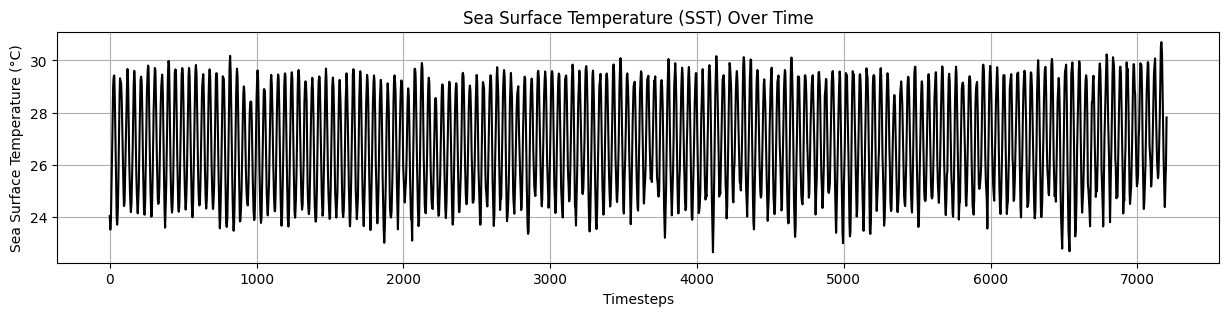

In [12]:
# Plotting the sea surface temperature (sst) over time
plt.figure(figsize=(15, 3))
plt.plot(df_interpolated.index, df_interpolated['sst'],  color="black", alpha = 1)
#plt.plot(df_north_interpolated.index, df_north_interpolated['sst'], color="dodgerblue",  alpha = 0.5)
plt.xlabel('Timesteps')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Sea Surface Temperature (SST) Over Time')
plt.grid(True)
plt.show()

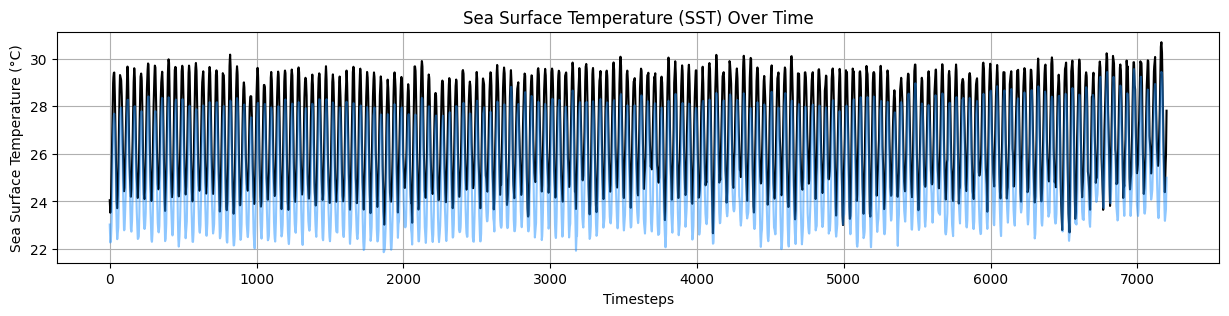

In [13]:
# Plotting the sea surface temperature (sst) over time
plt.figure(figsize=(15, 3))
plt.plot(df_interpolated.index, df_interpolated['sst'],  color="black", alpha = 1)
plt.plot(df_north_interpolated.index, df_north_interpolated['sst'], color="dodgerblue",  alpha = 0.5)
plt.xlabel('Timesteps')
plt.ylabel('Sea Surface Temperature (°C)')
plt.title('Sea Surface Temperature (SST) Over Time')
plt.grid(True)
plt.show()

In [14]:
df_interpolated.head()

,time,sst
0,1870-01-16 11:59:59.505615234,24.048920
1,1870-01-24 07:55:09.465400535,23.911687
2,1870-02-01 03:50:19.425185837,23.774455
3,1870-02-08 23:45:29.384971138,23.637222
4,1870-02-16 19:40:39.344756440,23.524403


In [19]:
df_interpolated.drop('time', axis=1, inplace=True)
df_interpolated.head()

,sst
0,24.048920
1,23.911687
2,23.774455
3,23.637222
4,23.524403


In [20]:
df_interpolated.dtypes

sst    float64
dtype: object

In [21]:
df_global_normalized = df_interpolated.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
df_global_normalized.head()

,sst
0,0.172796
1,0.155716
2,0.138635
3,0.121555
4,0.107513


In [23]:
df_global_normalized.to_csv("../data/global_temp.csv")